# Stacked Autoencoder를 사용한 MNIST
* dataset : `tf.examples.tutorials.mnist`은 삭제될 예정이므로 대신 `tf.keras.datasets.mnist`를 사용

In [1]:
import tensorflow as tf
import numpy as np

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [2]:
# for test by SOO
if 0:
    print(type(X_train), type(y_train), type(X_test), type(y_test))
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    print(X_train[0, 5, :])
    print(y_train[:5])

In [3]:
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [4]:
# for test by SOO
if 0:
    print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape)
    print(X_train[0,200:210])
    print(y_train[:5])

In [5]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))  # [34191 23679 44684 ... 38158   860 15795]
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

## 한 번에 모든 층을 훈련하기
* 3개의 은닉층과 1개의 출력층(즉, 두 개를 적층)을 가진 적층 오토인코더를 만들어 보겠음
* ELU 활성화 함수와 He 초기화, L2 정규화를 사용하겠음

In [6]:
import tensorflow as tf

# 일관된 출력을 위해 유사난수 초기화
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [7]:
# for test by SOO
if 1:
    from functools import partial
    
    def power(base, exponent):
        return base ** exponent

    square = partial(power, exponent=2)
    cube = partial(power, exponent=3)
        
    print(square(10))
    print(cube(10))

100
1000


In [8]:
reset_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # 코딩 유닛
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

he_init = tf.variance_scaling_initializer() # He 초기화
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
my_dense_layer = partial(tf.layers.dense,
                         activation=tf.nn.elu,
                         kernel_initializer=he_init,
                         kernel_regularizer=l2_regularizer)

hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3 = my_dense_layer(hidden2, n_hidden3)
outputs = my_dense_layer(hidden3, n_outputs, activation=None)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_losses)

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver() 

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


In [9]:
# for test by SOO
if 0:
    reconstruction_loss

In [10]:
# for test by SOO
if 0:
    reg_losses

* 이제 훈련시켜 보자! 여기에서는 타깃 값을 주입하지 않음(y_batch가 사용되지 않음). 이는 비지도 학습임.

In [11]:
import sys

n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = len(X_train) // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="") 
            sys.stdout.flush()                                          
            X_batch, y_batch = next(shuffle_batch(X_train, y_train, batch_size))
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})   
        print("\t{}".format(epoch), "훈련 MSE:", loss_train)
        saver.save(sess, "./save/my_model_all_layers.ckpt")

99%	0 훈련 MSE: 0.020135032
99%	1 훈련 MSE: 0.011458882
99%	2 훈련 MSE: 0.011783835
99%	3 훈련 MSE: 0.011677826
99%	4 훈련 MSE: 0.011752363


In [12]:
import os
import sys

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# 한글출력
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 폴더
PROJECT_ROOT_DIR = "."

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, fig_id + ".png")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)
    
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

* 재구성 오차 측정 함수 : 모델을 로드하고 테스트 세트에서 이를 평가한 다음 원본 이미지와 재구성 이미지를 그림

In [13]:
# for test by SOO
if 0:
    print(X_test.shape)  # (10000, 784)
    print(X_test[0].shape)  # (784)
    print(X_test[:2].shape)  # (2, 784)

In [14]:
# for test by SOO
if 0:
    n_test_digits = 2
    for digit_index in range(n_test_digits):
        fig = plt.figure(figsize=(8, 3 * n_test_digits))
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])

In [15]:
def show_reconstructed_digits(X, outputs, model_path = None, n_test_digits = 2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        outputs_val = outputs.eval(feed_dict={X: X_test[:n_test_digits]})

    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])

INFO:tensorflow:Restoring parameters from ./save/my_model_all_layers.ckpt


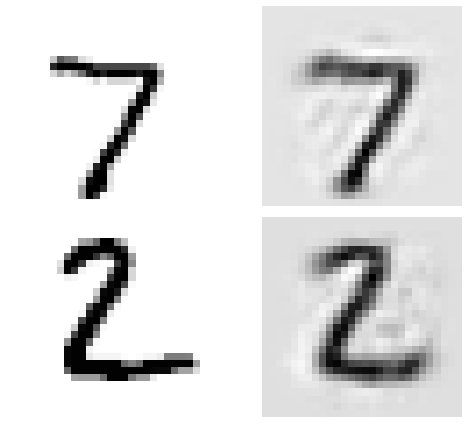

In [16]:
show_reconstructed_digits(X, outputs, "./save/my_model_all_layers.ckpt")
save_fig("reconstruction_plot")

## 가중치 묶기
* 인코더와 디코더의 가중치를 묶는 일은 자주 있음(`weights_decoder = tf.transpose(weights_encoder)`)
* 안타깝지만 `tf.layers.dense()` 함수를 사용해서 이렇게 하기는 불가능함(매우 어려움)
* 수동으로 직접 오토인코더를 만들어야 함

In [17]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # 코딩 유닛
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0005

In [18]:
activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.transpose(weights2, name="weights3")  # 가중치 묶기
weights4 = tf.transpose(weights1, name="weights4")  # 가중치 묶기

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(weights1) + regularizer(weights2)
loss = reconstruction_loss + reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [19]:
saver = tf.train.Saver()

In [20]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = len(X_train) // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = next(shuffle_batch(X_train, y_train, batch_size))
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\t{}".format(epoch), "훈련 MSE:", loss_train)
        saver.save(sess, "./save/my_model_tying_weights.ckpt")

99%	0 훈련 MSE: 0.017813876
99%	1 훈련 MSE: 0.01650707
99%	2 훈련 MSE: 0.018105883
99%	3 훈련 MSE: 0.018026385
99%	4 훈련 MSE: 0.017611641


INFO:tensorflow:Restoring parameters from ./save/my_model_tying_weights.ckpt


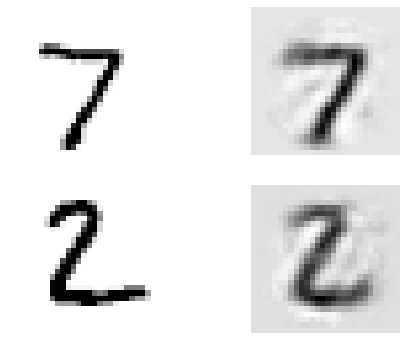

In [21]:
show_reconstructed_digits(X, outputs, "./save/my_model_tying_weights.ckpt")

## 여러 개의 그래프에서 오토인코더를 따로따로 훈련하기
* 하나의 오토인코더를 따로따로 훈련하는 방법이 많이 있음
* 첫 번째 방법은 각 오토인코더를 다른 그래프를 사용하여 훈련하는 것임
* 그런 다음 이런 오토인코더의 가중치와 편향을 복사해 초깃값으로 지정해서 적층 오토인코더를 만듬

* 하나의 오토인코더를 훈련하고 변환된 훈련 세트(즉, 은닉층의 출력)와 모델 파라미터를 반환하는 함수 생성

In [22]:
import numpy.random as rnd

reset_graph()

from functools import partial

def train_autoencoder(X_train, n_neurons, n_epochs, batch_size,
                      learning_rate = 0.01, l2_reg = 0.0005, seed=42,
                      hidden_activation=tf.nn.elu,
                      output_activation=tf.nn.elu):
    graph = tf.Graph()
    with graph.as_default():
        tf.set_random_seed(seed)

        n_inputs = X_train.shape[1]

        X = tf.placeholder(tf.float32, shape=[None, n_inputs])
        
        my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=tf.variance_scaling_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_reg))

        hidden = my_dense_layer(X, n_neurons, activation=hidden_activation, name="hidden")
        outputs = my_dense_layer(hidden, n_inputs, activation=output_activation, name="outputs")

        reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

        reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = tf.add_n([reconstruction_loss] + reg_losses)

        optimizer = tf.train.AdamOptimizer(learning_rate)
        training_op = optimizer.minimize(loss)

        init = tf.global_variables_initializer()

    with tf.Session(graph=graph) as sess:
        init.run()
        for epoch in range(n_epochs):
            n_batches = len(X_train) // batch_size
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                indices = rnd.permutation(len(X_train))[:batch_size]
                X_batch = X_train[indices]
                sess.run(training_op, feed_dict={X: X_batch})
            loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
            print("\t{}".format(epoch), "훈련 MSE:", loss_train)
        params = dict([(var.name, var.eval()) for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)])
        hidden_val = hidden.eval(feed_dict={X: X_train})
        return hidden_val, params["hidden/kernel:0"], params["hidden/bias:0"], params["outputs/kernel:0"], params["outputs/bias:0"]

* 이제 두 개의 오토인코더를 훈련시켜 보자
* 첫 번째는 훈련 데이터를 사용하고 두 번째는 첫 번째 오토인코더의 은닉층 출력을 사용해 훈련시킴

In [23]:
hidden_output, W1, b1, W4, b4 = train_autoencoder(X_train, n_neurons=300, n_epochs=4, batch_size=150,
                                                  output_activation=None)
_, W2, b2, W3, b3 = train_autoencoder(hidden_output, n_neurons=150, n_epochs=4, batch_size=150)

99%	0 훈련 MSE: 0.018396942
99%	1 훈련 MSE: 0.017695118
99%	2 훈련 MSE: 0.019602956
99%	3 훈련 MSE: 0.019349579
99%	0 훈련 MSE: 0.004570482
99%	1 훈련 MSE: 0.0048023676
99%	2 훈련 MSE: 0.004774678
99%	3 훈련 MSE: 0.0044500832


* 마지막으로 방금전 훈련한 오토인코더의 가중치와 편향을 재사용하여 적층 오토인코더를 만듬

In [24]:
reset_graph()

n_inputs = 28*28

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden1 = tf.nn.elu(tf.matmul(X, W1) + b1)
hidden2 = tf.nn.elu(tf.matmul(hidden1, W2) + b2)
hidden3 = tf.nn.elu(tf.matmul(hidden2, W3) + b3)
outputs = tf.matmul(hidden3, W4) + b4

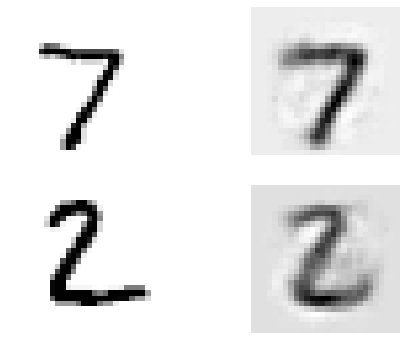

In [25]:
show_reconstructed_digits(X, outputs)

## 하나의 그래프에서 오토인코더를 따로따로 훈련하기
* 하나의 그래프를 사용하는 방법도 있음
* 이 방법은 전체 적층 오토인코더를 위한 그래프를 만들지만 각 오토인코더를 독립적으로 훈련하기 위한 연산도 추가함
* 단계 1은 맨 아래층과 맨 윗층을 훈련하고(즉, 첫 번째 오토인코더), 단계 2는 두 개의 가운데 층을 훈련함(즉, 두 번째 오토인코더).

In [26]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # 코딩 유닛
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_hidden3])
weights4_init = initializer([n_hidden3, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")
weights4 = tf.Variable(weights4_init, dtype=tf.float32, name="weights4")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

In [27]:
optimizer = tf.train.AdamOptimizer(learning_rate)

with tf.name_scope("phase1"):
    phase1_outputs = tf.matmul(hidden1, weights4) + biases4  # hidden2와 hidden3 통과합니다
    phase1_reconstruction_loss = tf.reduce_mean(tf.square(phase1_outputs - X))
    phase1_reg_loss = regularizer(weights1) + regularizer(weights4)
    phase1_loss = phase1_reconstruction_loss + phase1_reg_loss
    phase1_training_op = optimizer.minimize(phase1_loss)

with tf.name_scope("phase2"):
    phase2_reconstruction_loss = tf.reduce_mean(tf.square(hidden3 - hidden1))
    phase2_reg_loss = regularizer(weights2) + regularizer(weights3)
    phase2_loss = phase2_reconstruction_loss + phase2_reg_loss
    train_vars = [weights2, biases2, weights3, biases3]
    phase2_training_op = optimizer.minimize(phase2_loss, var_list=train_vars) # hidden1 동결

In [28]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [29]:
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("훈련 단계 #{}".format(phase + 1))
        for epoch in range(n_epochs[phase]):
            n_batches = len(X_train) // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                X_batch, y_batch = next(shuffle_batch(X_train, y_train, batch_sizes[phase]))
                sess.run(training_ops[phase], feed_dict={X: X_batch})
            loss_train = reconstruction_losses[phase].eval(feed_dict={X: X_batch})
            print("\t{}".format(epoch), "훈련 MSE:", loss_train)
            saver.save(sess, "./save/my_model_one_at_a_time.ckpt")
    loss_test = reconstruction_loss.eval(feed_dict={X: X_test})
    print("테스트 MSE:", loss_test)

훈련 단계 #1
99%	0 훈련 MSE: 0.007932797
99%	1 훈련 MSE: 0.0073406156
99%	2 훈련 MSE: 0.0077496944
99%	3 훈련 MSE: 0.0077196443
훈련 단계 #2
99%	0 훈련 MSE: 0.19434568
99%	1 훈련 MSE: 0.00553254
99%	2 훈련 MSE: 0.0029219496
99%	3 훈련 MSE: 0.0023317905
테스트 MSE: 0.009825974


## 동결 층의 출력을 캐싱하기

In [30]:
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("훈련 단계 #{}".format(phase + 1))
        if phase == 1:
            hidden1_cache = hidden1.eval(feed_dict={X: X_train})
        for epoch in range(n_epochs[phase]):
            n_batches = len(X_train) // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                if phase == 1:
                    indices = rnd.permutation(len(X_train))
                    hidden1_batch = hidden1_cache[indices[:batch_sizes[phase]]]
                    feed_dict = {hidden1: hidden1_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
                else:
                    X_batch, y_batch = next(shuffle_batch(X_train, y_train, batch_sizes[phase]))
                    feed_dict = {X: X_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
            loss_train = reconstruction_losses[phase].eval(feed_dict=feed_dict)
            print("\t{}".format(epoch), "훈련 MSE:", loss_train)
            saver.save(sess, "./save/my_model_cache_frozen.ckpt")
    loss_test = reconstruction_loss.eval(feed_dict={X: X_test})
    print("테스트 MSE:", loss_test)

훈련 단계 #1
99%	0 훈련 MSE: 0.0081470255
99%	1 훈련 MSE: 0.007710265
99%	2 훈련 MSE: 0.007226933
99%	3 훈련 MSE: 0.007944853
훈련 단계 #2
99%	0 훈련 MSE: 0.31889656
99%	1 훈련 MSE: 0.0065013347
99%	2 훈련 MSE: 0.0027700341
99%	3 훈련 MSE: 0.002272428
테스트 MSE: 0.009815992


## 재구성 시각화

INFO:tensorflow:Restoring parameters from ./save/my_model_one_at_a_time.ckpt


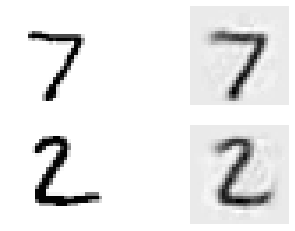

In [31]:
n_test_digits = 2
# X_test = mnist.test.images[:n_test_digits]

with tf.Session() as sess:
    saver.restore(sess, "./save/my_model_one_at_a_time.ckpt") # not shown in the book
    outputs_val = outputs.eval(feed_dict={X: X_test[:n_test_digits]})

def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

for digit_index in range(n_test_digits):
    plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
    plot_image(X_test[digit_index])
    plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
    plot_image(outputs_val[digit_index])

## 특성 시각화

INFO:tensorflow:Restoring parameters from ./save/my_model_one_at_a_time.ckpt


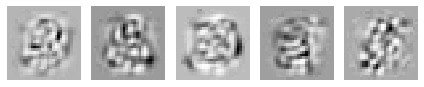

In [32]:
with tf.Session() as sess:
    saver.restore(sess, "./save/my_model_one_at_a_time.ckpt")
    weights1_val = weights1.eval()

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plot_image(weights1_val.T[i])

save_fig("extracted_features_plot")
plt.show() 

# 비지도 사전훈련
* MNIST 분류 문제를 위한 작은 신경망 생성

In [33]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_outputs = 10

learning_rate = 0.01
l2_reg = 0.0005

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
y = tf.placeholder(tf.int32, shape=[None])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_outputs), name="biases3")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
logits = tf.matmul(hidden2, weights3) + biases3

cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
reg_loss = regularizer(weights1) + regularizer(weights2) + regularizer(weights3)
loss = cross_entropy + reg_loss
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
pretrain_saver = tf.train.Saver([weights1, weights2, biases1, biases2])
saver = tf.train.Saver()

* (사전훈련 없이)평범하게 훈련시킴

In [34]:
n_epochs = 4
batch_size = 150
n_labeled_instances = 20000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indices = rnd.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = X_train[indices], y_train[indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("\t{}".format(epoch), "검증 세트 정확도:", accuracy_val, end=" ")
        saver.save(sess, "./save//my_model_supervised.ckpt")
        test_val = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print("\t테스트 정확도:", test_val)

99%	0 검증 세트 정확도: 0.93333334 	테스트 정확도: 0.9191
99%	1 검증 세트 정확도: 0.97333336 	테스트 정확도: 0.9371
99%	2 검증 세트 정확도: 0.9866667 	테스트 정확도: 0.9318
99%	3 검증 세트 정확도: 0.97333336 	테스트 정확도: 0.9404


* 사전 훈련된 오토인코더의 첫 두개의 층을 재사용해 보겠음

In [35]:
n_epochs = 4
batch_size = 150
n_labeled_instances = 20000

#training_op = optimizer.minimize(loss, var_list=[weights3, biases3])  # layers 1와 2를 동결 (선택사항)

with tf.Session() as sess:
    init.run()
    pretrain_saver.restore(sess, "./save/my_model_cache_frozen.ckpt")
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indices = rnd.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = X_train[indices], y_train[indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("\t{}".format(epoch), "훈련 정확도:", accuracy_val, end="\t")
        saver.save(sess, "./save/my_model_supervised_pretrained.ckpt")
        test_val = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print("\t테스트 정확도:", test_val)

INFO:tensorflow:Restoring parameters from ./save/my_model_cache_frozen.ckpt
99%	0 훈련 정확도: 0.96		테스트 정확도: 0.9193
99%	1 훈련 정확도: 0.96		테스트 정확도: 0.9383
99%	2 훈련 정확도: 0.96666664		테스트 정확도: 0.9442
99%	3 훈련 정확도: 0.9866667		테스트 정확도: 0.9541


# 적층 잡음제거 오토인코더
* 가우시안 잡음을 사용함

In [36]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # 코딩 유닛
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

In [37]:
noise_level = 1.0

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_noisy = X + noise_level * tf.random_normal(tf.shape(X))

hidden1 = tf.layers.dense(X_noisy, n_hidden1, activation=tf.nn.relu,
                          name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                          name="hidden2")                           
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, 
                          name="hidden3")                           
outputs = tf.layers.dense(hidden3, n_outputs, name="outputs")       

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE

In [38]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [39]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = len(X_train) // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = next(shuffle_batch(X_train, y_train, batch_size))
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\t{}".format(epoch), "훈련 MSE:", loss_train)
        saver.save(sess, "./save/my_model_stacked_denoising_gaussian.ckpt")

99%	0 훈련 MSE: 0.04428355
99%	1 훈련 MSE: 0.038521696
99%	2 훈련 MSE: 0.043377947
99%	3 훈련 MSE: 0.042811163
99%	4 훈련 MSE: 0.041684892
99%	5 훈련 MSE: 0.041679293
99%	6 훈련 MSE: 0.042928487
99%	7 훈련 MSE: 0.040650867
99%	8 훈련 MSE: 0.044437032
99%	9 훈련 MSE: 0.042796995


* 드롭아웃을 사용함

In [40]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # 코딩 유닛
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

In [41]:
dropout_rate = 0.3

training = tf.placeholder_with_default(False, shape=(), name='training')

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu,
                          name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, 
                          name="hidden2")                            
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu,
                          name="hidden3")                            
outputs = tf.layers.dense(hidden3, n_outputs, name="outputs")       

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE

Instructions for updating:
Use keras.layers.dropout instead.


In [42]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [43]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = len(X_train) // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = next(shuffle_batch(X_train, y_train, batch_size))
            sess.run(training_op, feed_dict={X: X_batch, training: True})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\t{}".format(epoch), "훈련 MSE:", loss_train)
        saver.save(sess, "./save/my_model_stacked_denoising_dropout.ckpt")

99%	0 훈련 MSE: 0.028612738
99%	1 훈련 MSE: 0.023636593
99%	2 훈련 MSE: 0.025780853
99%	3 훈련 MSE: 0.024078924
99%	4 훈련 MSE: 0.023588093
99%	5 훈련 MSE: 0.023056729
99%	6 훈련 MSE: 0.023624336
99%	7 훈련 MSE: 0.022727242
99%	8 훈련 MSE: 0.023716277
99%	9 훈련 MSE: 0.023723472


INFO:tensorflow:Restoring parameters from ./save/my_model_stacked_denoising_dropout.ckpt


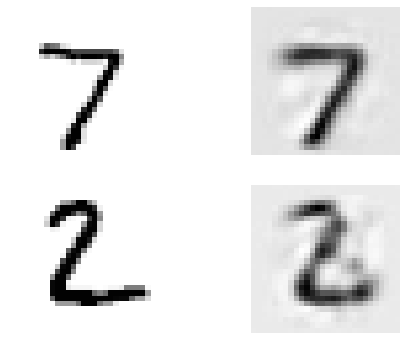

In [44]:
show_reconstructed_digits(X, outputs, "./save/my_model_stacked_denoising_dropout.ckpt")